In [18]:
import sys
sys.path.insert(0,"..")

from src.utils import read_file_with_custom_data_types

df = read_file_with_custom_data_types("../data/transformed/transform.csv")

df.head()

,id,created_at,updated_at,name,description,gsf_standards_version,estimated_annual_credits,crediting_period_start_date,crediting_period_end_date,methodology,...,Goal_2,Goal_11,Goal_9,Goal_10,Goal_16,Goal_14,crediting_days,VER_sold_percentage,VER_sold_percentage_per_day,continent_code
0,3653,2022-07-25 14:23:52+00:00,2023-03-15 01:54:01+00:00,GS10789 VPA10: Efficient and Clean Cooking for...,This VPA deploys highly efficient improved cha...,Gold Standard for the Global Goals,311327,2021-03-30,2026-03-30,GS TPDDTEC v3.1,...,0,0,0,0,0,0,1826,0.0,0.0,AF
1,3649,2022-07-20 14:54:25+00:00,2023-03-27 18:37:46+00:00,TASC Clean Cooking PoA – VPA 3 (Zambia),The goal of the proposed project is to distrib...,Gold Standard for the Global Goals,96484,2021-09-21,2026-09-20,GS TPDDTEC v3.1,...,0,0,0,0,0,0,1825,0.0,0.0,AF
2,3595,2022-06-23 05:52:18+00:00,2023-03-28 12:23:43+00:00,GS10818 - Dissemination of Improved Cookstoves...,The project involves providing access to clean...,Gold Standard for the Global Goals,39126,2022-03-01,2027-03-01,AMS-II.G. Energy Efficiency Measures in Therma...,...,0,0,0,0,0,0,1826,0.0,0.0,AS
3,3594,2022-06-23 05:52:03+00:00,2023-03-28 12:23:07+00:00,GS10818 - Dissemination of Improved Cookstoves...,The project involves providing access to clean...,Gold Standard for the Global Goals,39126,2022-01-21,2027-01-21,AMS-II.G. Energy Efficiency Measures in Therma...,...,0,0,0,0,0,0,1826,0.0,0.0,AS
4,3593,2022-06-23 05:51:46+00:00,2023-03-28 12:22:37+00:00,GS10818 - Dissemination of Improved Cookstoves...,The project involves providing access to clean...,Gold Standard for the Global Goals,39126,2021-12-20,2026-12-20,AMS-II.G. Energy Efficiency Measures in Therma...,...,0,0,0,0,0,0,1826,0.0,0.0,AS


In [20]:
df.Goal_1.value_counts()

0    1194
1     194
Name: Goal_1, dtype: int64

In [10]:
df.continent_code.values

array(['AF', 'AF', 'AS', ..., 'AF', 'AS', 'AS'], dtype=object)

In [11]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler

np.random.seed(108)

numerical_columns = ["VER_sold_percentage_per_day"]
categorical_columns = [
    "continent_code",
    "size",
    "type",
]

num_pipeline= Pipeline(
    steps=[
    # ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
    ]
)

cat_pipeline=Pipeline(
    steps=[
    # ("imputer",SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ("scaler",StandardScaler(with_mean=False))
    ]
)

preprocessor=ColumnTransformer(
    [
    ("num_pipeline",num_pipeline,numerical_columns),
    ("cat_pipelines",cat_pipeline,categorical_columns)
    ],
    #remainder='passthrough',
    verbose_feature_names_out = False
)

preprocessor.set_output(transform="pandas")

X = preprocessor.fit_transform(df)
X.columns


Index(['VER_sold_percentage_per_day', 'continent_code_AF', 'continent_code_AS',
       'continent_code_EU', 'continent_code_OC', 'continent_code_SA',
       'continent_code_nan', 'size_Large Scale', 'size_Micro Scale',
       'size_Small Scale', 'type_A/R', 'type_Biogas - Cogeneration',
       'type_Biogas - Electricity', 'type_Biogas - Heat',
       'type_Biomass, or Liquid Biofuel - Electricity',
       'type_Biomass, or Liquid Biofuel - Heat',
       'type_Energy Efficiency - Domestic',
       'type_Energy Efficiency - Industrial',
       'type_Energy Efficiency - Public Sector',
       'type_Energy Efficiency - Transport Sector', 'type_Geothermal',
       'type_Other', 'type_Small, Low - Impact Hydro',
       'type_Solar Thermal - Electricity', 'type_Solar Thermal - Heat',
       'type_Wind'],
      dtype='object')

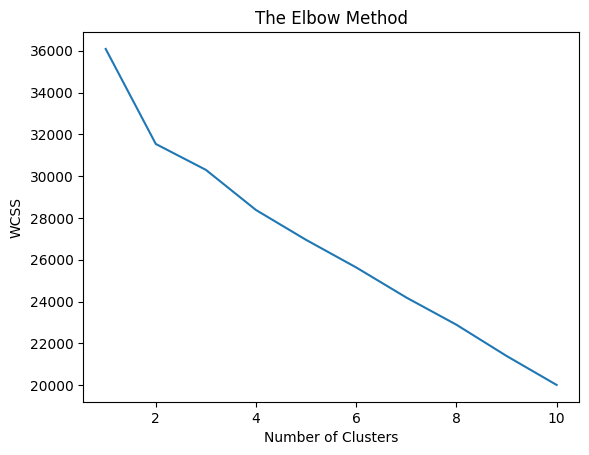

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',n_init=1, random_state=108)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [13]:
kmeans=KMeans(n_clusters=3,init='k-means++',n_init=1, random_state=108)
y_kmeans=kmeans.fit_predict(X)

df['K_Means_Cluster'] = y_kmeans

df['K_Means_Cluster'].value_counts()

1    686
2    445
0    257
Name: K_Means_Cluster, dtype: int64

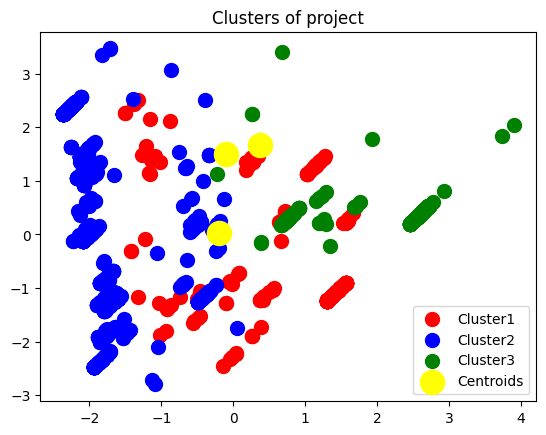

In [14]:
from sklearn.decomposition import PCA


# Reduce the dimensions using PCA
pca = PCA(n_components=2)
X_ = pca.fit_transform(X)

#Visualize the clusters

plt.scatter(X_[y_kmeans==0,0],X_[y_kmeans==0,1],s=100,c='red',label='Cluster1')
plt.scatter(X_[y_kmeans==1,0],X_[y_kmeans==1,1],s=100,c='blue',label='Cluster2')
plt.scatter(X_[y_kmeans==2,0],X_[y_kmeans==2,1],s=100,c='green',label='Cluster3')
# plt.scatter(X_[y_kmeans==3,0],X_[y_kmeans==3,1],s=100,c='cyan',label='Cluster4')
# plt.scatter(X_[y_kmeans==4,0],X_[y_kmeans==4,1],s=100,c='magenta',label='Cluster5')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroids')

plt.title('Clusters of project')
plt.legend()
plt.show()


### Using Fuzzy Clustering

In [15]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz

# Set the number of clusters and fuzziness parameter
num_clusters = 3
fuzziness_param = 2

# Initialize the cluster centers and membership matrix
#cluster_centers, membership_matrix
cluster_centers, cluster_membership, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X.T, num_clusters, fuzziness_param, error=0.005, maxiter=1000, init=None)

# Assign each data point to the cluster with the highest membership probability
cluster_labels = np.argmax(cluster_membership, axis=0)

# Print the cluster centers and number of data points in each cluster
for i in range(num_clusters):
    cluster_data = X.iloc[cluster_labels == i]
    print(f'Cluster {i+1} center: {cluster_centers[:, i]}')
    print(f'Number of data points in cluster {i+1}: {len(cluster_data)}')



df['Fuzzy_Cluster'] = cluster_labels

print()
print(df['Fuzzy_Cluster'].value_counts())

Cluster 1 center: [-0.28281473  0.22395769 -0.04045024]
Number of data points in cluster 1: 415
Cluster 2 center: [0.25489876 1.77575963 0.11549949]
Number of data points in cluster 2: 622
Cluster 3 center: [1.63897221 0.21281803 1.79350989]
Number of data points in cluster 3: 351

1    622
0    415
2    351
Name: Fuzzy_Cluster, dtype: int64


In [16]:
df.to_csv('../data/predictions/clustered.csv',index=False, header=True)